In [35]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
UScomments = pd.read_csv("~/Downloads/UScomments.csv", error_bad_lines=False)

b'Skipping line 41589: expected 4 fields, saw 11\nSkipping line 51628: expected 4 fields, saw 7\nSkipping line 114465: expected 4 fields, saw 5\n'
b'Skipping line 142496: expected 4 fields, saw 8\nSkipping line 189732: expected 4 fields, saw 6\nSkipping line 245218: expected 4 fields, saw 7\n'
b'Skipping line 388430: expected 4 fields, saw 5\n'
/Users/yingkaima/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (2,3) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [3]:
UScomments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 691400 entries, 0 to 691399
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   video_id      691400 non-null  object
 1   comment_text  691375 non-null  object
 2   likes         691400 non-null  object
 3   replies       691400 non-null  object
dtypes: object(4)
memory usage: 21.1+ MB


In [4]:
UScomments.isnull().sum(axis=0)

video_id         0
comment_text    25
likes            0
replies          0
dtype: int64

In [5]:
UScomments = UScomments.dropna()

In [6]:
UScomments.head()

,video_id,comment_text,likes,replies
0,XpVt6Z1Gjjo,Logan Paul it's yo big day ‼️‼️‼️,4,0
1,XpVt6Z1Gjjo,I've been following you from the start of your...,3,0
2,XpVt6Z1Gjjo,Say hi to Kong and maverick for me,3,0
3,XpVt6Z1Gjjo,MY FAN . attendance,3,0
4,XpVt6Z1Gjjo,trending 😉,3,0


# Visualization

## 1. Number of Comments

In [36]:
video_with_most_comments = UScomments.value_counts('video_id').reset_index()

In [37]:
video_with_most_comments.columns = ['video_id', 'number_of_comments']

In [39]:
video_with_most_comments_top10 = video_with_most_comments.head(10)

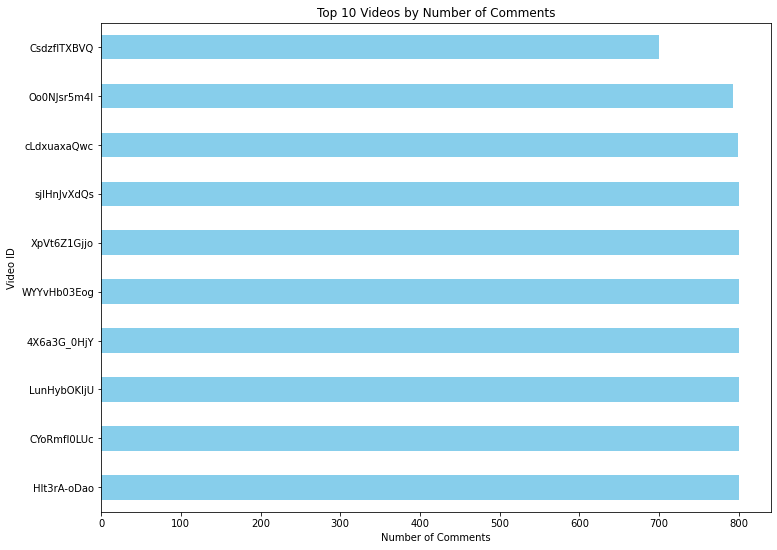

In [41]:
ax = video_with_most_comments_top10.plot.barh(color=["SkyBlue"], rot=0, title="Top 10 Videos by Number of Comments", 
                                        figsize=(12, 9), fontsize=10, legend=False)
ax.set_xlabel("Number of Comments")
ax.set_ylabel("Video ID")
y = range(0,10)
yi = video_with_most_comments_top10['video_id']
plt.yticks(y, yi)

plt.show()

array([[<AxesSubplot:title={'center':'number_of_comments'}>]],
      dtype=object)

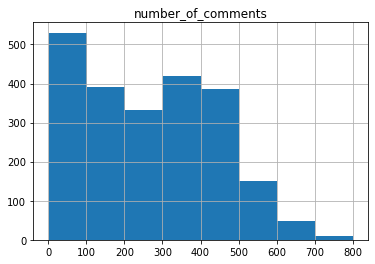

In [64]:
video_with_most_comments.hist(column='number_of_comments',bins=8)

## 2. Number of Likes

In [16]:
UScomments.loc[41587]

video_id         _ANP3HR1jsM
comment_text    comment_text
likes                  likes
replies              replies
Name: 41587, dtype: object

In [17]:
UScomments = UScomments.drop(41587, axis=0)

In [65]:
video_with_most_likes = UScomments.groupby('video_id').sum('likes').reset_index()

In [66]:
video_with_most_likes

,video_id,likes
0,--JinobXWPk,19
1,-1fzGnFwz9M,874
2,-3AGlBYyLjo,2
3,-5sCWsLlTCI,494
4,-6Zc8Co2H3w,38
...,...,...
2261,zqE-ultsWt0,129
2262,zrOHeEA14kQ,145
2263,zuKX0fPlo2Q,0
2264,zuUQDdWNAPc,687


In [67]:
video_with_most_likes = video_with_most_likes.sort_values('likes', ascending=False)

In [68]:
video_with_most_likes_top10 = video_with_most_likes.head(10)

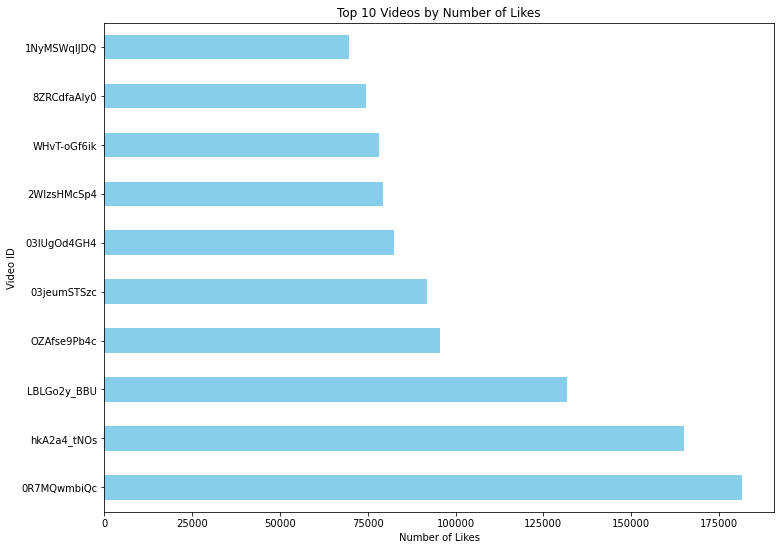

In [69]:
ax = video_with_most_likes_top10.plot.barh(color=["SkyBlue"], rot=0, title="Top 10 Videos by Number of Likes", 
                                        figsize=(12, 9), fontsize=10, legend=False)
ax.set_xlabel("Number of Likes")
ax.set_ylabel("Video ID")
y = range(0,10)
yi = video_with_most_likes_top10['video_id']
plt.yticks(y, yi)

plt.show()

array([[<AxesSubplot:title={'center':'likes'}>]], dtype=object)

<Figure size 720x360 with 0 Axes>

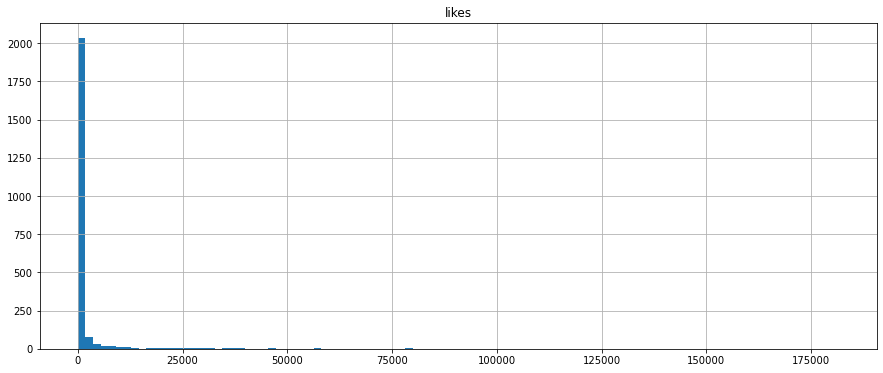

In [87]:
plt.figure (figsize=(10,5))
video_with_most_likes.hist(column='likes',bins=100,figsize=(15,6))

In [89]:
video_with_most_likes['likes'].describe()

count      2266.000000
mean       1776.084289
std        8892.846396
min           0.000000
25%          42.000000
50%         115.000000
75%         467.750000
max      181555.000000
Name: likes, dtype: float64

In [92]:
video_with_most_likes_controlled = video_with_most_likes[(video_with_most_likes['likes'] >= 42) & (video_with_most_likes['likes'] <= 467.75)]

array([[<AxesSubplot:title={'center':'likes'}>]], dtype=object)

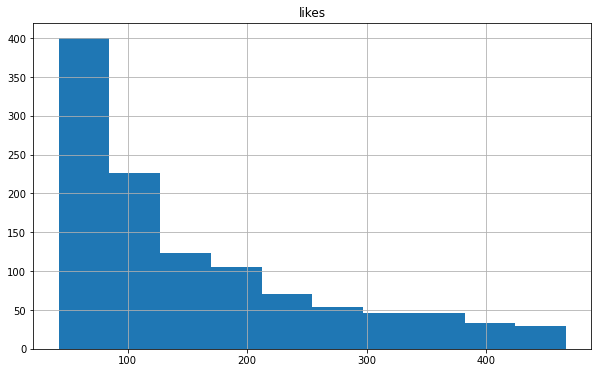

In [94]:
video_with_most_likes_controlled.hist(column='likes',figsize=(10,6))

## 3. Sentiment Score

In [95]:
from nltk.tokenize import word_tokenize
import re, string, random
from nltk.tag import pos_tag
from nltk.stem.wordnet import WordNetLemmatizer

In [98]:
comment_tokenized = [word_tokenize(i) for i in UScomments['comment_text']]
len(comment_tokenized)

691374

In [99]:
def remove_noise(tokens, stop_words = ()):

    cleaned_tokens = []

    for token, tag in pos_tag(tokens):
        token = re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+#]|[!*\(\),]|'\
                       '(?:%[0-9a-fA-F][0-9a-fA-F]))+','', token)
        token = re.sub("(@[A-Za-z0-9_]+)","", token)

        if tag.startswith("NN"):
            pos = 'n'
        elif tag.startswith('VB'):
            pos = 'v'
        else:
            pos = 'a'

        lemmatizer = WordNetLemmatizer()
        token = lemmatizer.lemmatize(token, pos)

        if len(token) > 0 and token not in string.punctuation and token.lower() not in stop_words:
            cleaned_tokens.append(token.lower())
    return cleaned_tokens

In [100]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

print(remove_noise(comment_tokenized[0], stop_words))

['logan', 'paul', "'s", 'yo', 'big', 'day', '‼️‼️‼️']


In [101]:
comment_cleaned_tokens = []

for tokens in comment_tokenized:
    comment_cleaned_tokens.append(remove_noise(tokens, stop_words))

In [102]:
print(comment_tokenized[500])
print(comment_cleaned_tokens[500])

['4:30', 'the', 'universe', 'itself', 'is', 'comparable', 'to', 'the', 'human', 'brain', '.', 'Google', 'keyword', 'search', ':', 'images', ':', 'universe', '+', 'neuron']
['4:30', 'universe', 'comparable', 'human', 'brain', 'google', 'keyword', 'search', 'image', 'universe', 'neuron']


In [104]:
UScomments['comment_cleaned_tokens'] = [' '.join(x) for x in comment_cleaned_tokens]

In [113]:
UScomments.head()

,video_id,comment_text,likes,replies,comment_cleaned_tokens
0,XpVt6Z1Gjjo,Logan Paul it's yo big day ‼️‼️‼️,4,0,logan paul 's yo big day ‼️‼️‼️
1,XpVt6Z1Gjjo,I've been following you from the start of your...,3,0,'ve follow start vine channel see 365 vlogs
2,XpVt6Z1Gjjo,Say hi to Kong and maverick for me,3,0,say hi kong maverick
3,XpVt6Z1Gjjo,MY FAN . attendance,3,0,fan attendance
4,XpVt6Z1Gjjo,trending 😉,3,0,trend 😉


## *Convert emojis & emoticon into text*
https://studymachinelearning.com/text-preprocessing-handle-emoji-emoticon/

In [119]:
def remove_emoji(string):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F" # emoticons
                           u"\U0001F300-\U0001F5FF" # symbols & pictographs
                           u"\U0001F680-\U0001F6FF" # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF" # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', string)

remove_emoji("I like to eat 🍕")

'I like to eat '

In [120]:
cleaned_text = []

for text in UScomments['comment_cleaned_tokens']:
    cleaned_text.append(remove_emoji(text))

In [121]:
UScomments['comment_cleaned_tokens'] = cleaned_text

In [122]:
UScomments

,video_id,comment_text,likes,replies,comment_cleaned_tokens
0,XpVt6Z1Gjjo,Logan Paul it's yo big day ‼️‼️‼️,4,0,logan paul 's yo big day ‼‼‼
1,XpVt6Z1Gjjo,I've been following you from the start of your...,3,0,'ve follow start vine channel see 365 vlogs
2,XpVt6Z1Gjjo,Say hi to Kong and maverick for me,3,0,say hi kong maverick
3,XpVt6Z1Gjjo,MY FAN . attendance,3,0,fan attendance
4,XpVt6Z1Gjjo,trending 😉,3,0,trend
...,...,...,...,...,...
691395,EoejGgUNmVU,Лучшая,1,0,лучшая
691396,EoejGgUNmVU,qu'est ce que j'aimerais que tu viennes à Roan...,0,0,qu'est ce que j'aimerais que tu vienne à roanne
691397,EoejGgUNmVU,Ven a mexico! 😍 te amo LP,0,0,ven mexico te amo lp
691398,EoejGgUNmVU,Islığı yeter...,0,0,islığı yeter ...


In [109]:
try:
    import cPickle as pickle
except ImportError: 
    import pickle
import re

with open('Emoji_Dict.p', 'rb') as fp:
    Emoji_Dict = pickle.load(fp)
Emoji_Dict = {v: k for k, v in Emoji_Dict.items()}

def convert_emojis_to_word(text):
    for emot in Emoji_Dict:
        text = re.sub(r'('+emot+')', "_".join(Emoji_Dict[emot].replace(",","").replace(":","").split()), text)
    return text

text = "I won 🥇 in 🏏"
convert_emojis_to_word(text)

'I won 1st_place_medal in cricket'

In [118]:
cleaned_text = []

for text in UScomments['comment_cleaned_tokens']:
    cleaned_text.append(convert_emojis_to_word(text))

KeyboardInterrupt: 

In [110]:
try:
    import cPickle as pickle
except ImportError:
    import pickle  

with open('Emoticon_Dict.p', 'rb') as fp:
    Emoticon_Dict = pickle.load(fp)

def remove_emoticons(text):
    emoticon_pattern = re.compile(u'(' + u'|'.join(k for k in Emoticon_Dict) + u')')
    return emoticon_pattern.sub(r'', text)

remove_emoticons("Good Morning :-)")

'Good Morning '

In [123]:
cleaned_text = []

for i in UScomments['comment_cleaned_tokens']:
    cleaned_text.append(remove_emoticons(i))

In [124]:
UScomments

,video_id,comment_text,likes,replies,comment_cleaned_tokens
0,XpVt6Z1Gjjo,Logan Paul it's yo big day ‼️‼️‼️,4,0,logan paul 's yo big day ‼‼‼
1,XpVt6Z1Gjjo,I've been following you from the start of your...,3,0,'ve follow start vine channel see 365 vlogs
2,XpVt6Z1Gjjo,Say hi to Kong and maverick for me,3,0,say hi kong maverick
3,XpVt6Z1Gjjo,MY FAN . attendance,3,0,fan attendance
4,XpVt6Z1Gjjo,trending 😉,3,0,trend
...,...,...,...,...,...
691395,EoejGgUNmVU,Лучшая,1,0,лучшая
691396,EoejGgUNmVU,qu'est ce que j'aimerais que tu viennes à Roan...,0,0,qu'est ce que j'aimerais que tu vienne à roanne
691397,EoejGgUNmVU,Ven a mexico! 😍 te amo LP,0,0,ven mexico te amo lp
691398,EoejGgUNmVU,Islığı yeter...,0,0,islığı yeter ...


In [ ]:
USvideos.csv